# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

C:\Users\WIN10PX64\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

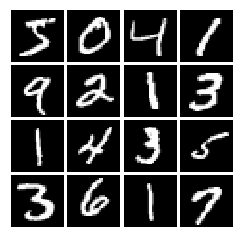

In [3]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    
    return tf.maximum(x, x * alpha)

Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [7]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    
    return tf.random_uniform([batch_size, dim],-1,1)


Make sure noise is the correct shape and type:

In [8]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [9]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        alpha = 0.01
        W1 = tf.get_variable("W1", shape = [784, 256], initializer=  tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable("b1", shape = [256])
        W2 = tf.get_variable("W2", shape = [256, 256], initializer=  tf.contrib.layers.xavier_initializer())
        b2 = tf.get_variable("b2", shape = [256])
        W3 = tf.get_variable("W3", shape = [256, 1], initializer=  tf.contrib.layers.xavier_initializer())
        b3 = tf.get_variable("b3", shape = [1])
        
        h1 = tf.matmul(x, W1) + b1
        a2 = leaky_relu(h1, alpha)
        h2 = tf.matmul(a2, W2) + b2
        a3 = leaky_relu(h2, alpha)
        logits = tf.matmul(a3, W3) + b3
        
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [10]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [11]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        noise_dim = z.shape[1]
        
        W1 = tf.get_variable("W1", shape = [noise_dim, 1024], initializer=  tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable("b1", shape = [1024])
        W2 = tf.get_variable("W2", shape = [1024, 1024], initializer=  tf.contrib.layers.xavier_initializer())
        b2 = tf.get_variable("b2", shape = [1024])
        W3 = tf.get_variable("W3", shape = [1024, 784], initializer=  tf.contrib.layers.xavier_initializer())
        b3 = tf.get_variable("b3", shape = [784])
        
        h1 = tf.matmul(z, W1) + b1
        a2 = tf.nn.relu(h1)
        h2 = tf.matmul(a2, W2) + b2
        a3 = tf.nn.relu(h2)
        h3 = tf.matmul(a3, W3) + b3
        img = tf.nn.tanh(h3)
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [12]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [13]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real) ,logits = logits_real))\
             + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake) ,logits = logits_fake))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake) ,logits = logits_fake)) 
    
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [14]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 6.02597e-17
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [15]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [16]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [19]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        it = 0
        # every show often, show a sample result
        for (minibatch, minbatch_y) in mnist:
            # run a batch of data through the network
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            #if D_loss_cur > 1.6:
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Epoch: {}, D: {:.4}, G:{:.4}'.format(epoch,D_loss_curr,G_loss_curr))
            if it % show_every == 0:
                samples = sess.run(G_sample)
                fig = show_images(samples[:16])
                plt.show()
                print()
            
            it += 1
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

Epoch: 0, D: 1.987, G:0.9962


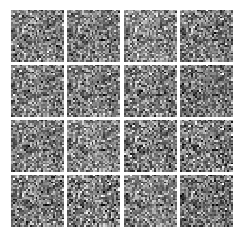


Epoch: 0, D: 0.1924, G:2.183
Epoch: 0, D: 1.967, G:1.109
Epoch: 0, D: 1.343, G:1.471
Epoch: 0, D: 1.282, G:1.005
Epoch: 0, D: 1.314, G:1.583


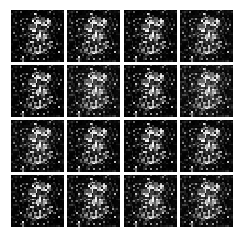


Epoch: 0, D: 2.033, G:0.3693
Epoch: 0, D: 1.148, G:1.73
Epoch: 0, D: 1.333, G:0.9193
Epoch: 0, D: 1.096, G:1.587
Epoch: 1, D: 1.589, G:1.508


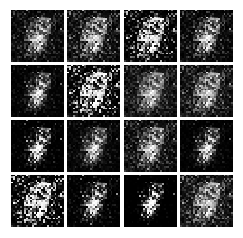


Epoch: 1, D: 0.9966, G:0.9964
Epoch: 1, D: 0.9257, G:1.364
Epoch: 1, D: 1.008, G:1.994
Epoch: 1, D: 1.097, G:2.343
Epoch: 1, D: 1.108, G:1.118


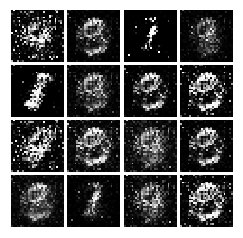


Epoch: 1, D: 1.431, G:1.811
Epoch: 1, D: 1.183, G:1.679
Epoch: 1, D: 1.224, G:0.7163
Epoch: 1, D: 1.073, G:1.081
Epoch: 2, D: 2.51, G:0.2254


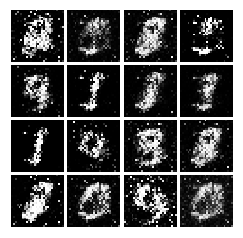


Epoch: 2, D: 1.119, G:1.878
Epoch: 2, D: 1.418, G:0.9693
Epoch: 2, D: 1.172, G:0.932
Epoch: 2, D: 1.342, G:1.062
Epoch: 2, D: 0.9954, G:1.875


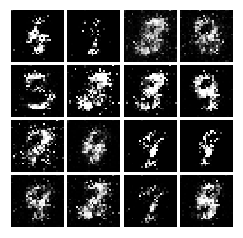


Epoch: 2, D: 1.173, G:1.071
Epoch: 2, D: 1.077, G:1.015
Epoch: 2, D: 1.188, G:1.214
Epoch: 2, D: 1.17, G:1.059
Epoch: 3, D: 1.398, G:1.057


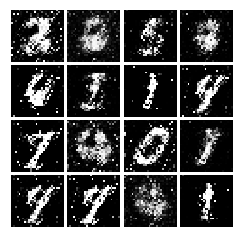


Epoch: 3, D: 1.161, G:0.6901
Epoch: 3, D: 1.178, G:0.8725
Epoch: 3, D: 1.163, G:0.4518
Epoch: 3, D: 1.212, G:1.009
Epoch: 3, D: 1.261, G:1.01


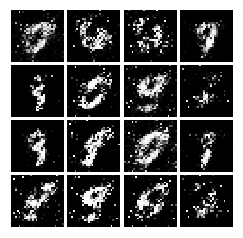


Epoch: 3, D: 1.171, G:1.004
Epoch: 3, D: 1.245, G:0.8818
Epoch: 3, D: 1.167, G:1.011
Epoch: 3, D: 1.329, G:0.9245
Epoch: 4, D: 1.156, G:0.9951


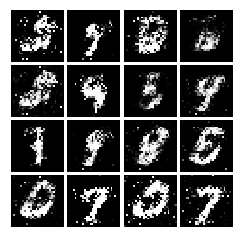


Epoch: 4, D: 1.273, G:0.8434
Epoch: 4, D: 1.361, G:0.8041
Epoch: 4, D: 1.293, G:0.8251
Epoch: 4, D: 1.255, G:0.9263
Epoch: 4, D: 1.44, G:0.7111


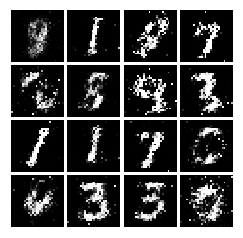


Epoch: 4, D: 1.182, G:0.8525
Epoch: 4, D: 1.164, G:0.9796
Epoch: 4, D: 1.25, G:0.8205
Epoch: 4, D: 1.309, G:0.8204
Epoch: 5, D: 1.442, G:0.8502


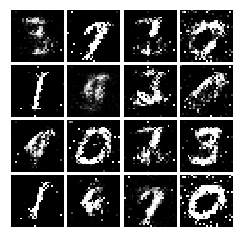


Epoch: 5, D: 1.34, G:0.8696
Epoch: 5, D: 1.412, G:0.7923
Epoch: 5, D: 1.262, G:0.8662
Epoch: 5, D: 1.395, G:0.8658
Epoch: 5, D: 1.398, G:0.8045


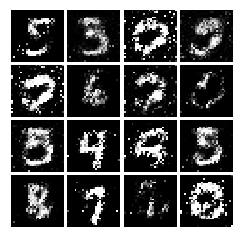


Epoch: 5, D: 1.329, G:0.836
Epoch: 5, D: 1.381, G:0.8332
Epoch: 5, D: 1.424, G:0.8165
Epoch: 5, D: 1.373, G:0.8388
Epoch: 6, D: 1.278, G:0.86


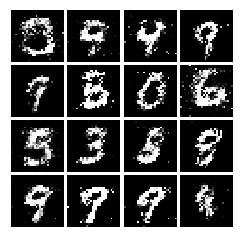


Epoch: 6, D: 1.311, G:0.8859
Epoch: 6, D: 1.31, G:0.7778
Epoch: 6, D: 1.217, G:1.17
Epoch: 6, D: 1.214, G:1.091
Epoch: 6, D: 1.281, G:0.8491


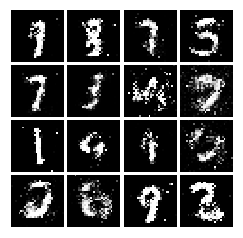


Epoch: 6, D: 1.279, G:0.866
Epoch: 6, D: 1.38, G:0.8546
Epoch: 6, D: 1.399, G:0.7514
Epoch: 6, D: 1.355, G:0.8355
Epoch: 7, D: 1.525, G:0.5369


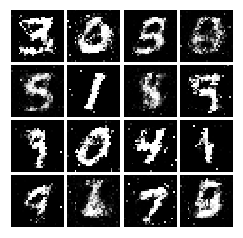


Epoch: 7, D: 1.384, G:0.7957
Epoch: 7, D: 1.39, G:0.7033
Epoch: 7, D: 1.36, G:0.9125
Epoch: 7, D: 1.352, G:0.8426
Epoch: 7, D: 1.292, G:0.8433


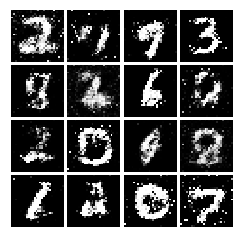


Epoch: 7, D: 1.334, G:0.7908
Epoch: 7, D: 1.333, G:0.8356
Epoch: 7, D: 1.362, G:0.7621
Epoch: 7, D: 1.377, G:0.8506
Epoch: 8, D: 1.388, G:0.8452


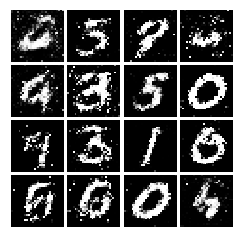


Epoch: 8, D: 1.371, G:0.8118
Epoch: 8, D: 1.368, G:0.8447
Epoch: 8, D: 1.322, G:0.7578
Epoch: 8, D: 1.326, G:0.7733
Epoch: 8, D: 1.33, G:0.7773


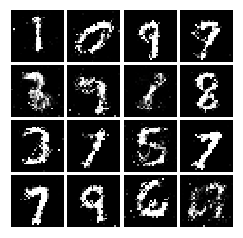


Epoch: 8, D: 1.343, G:0.8074
Epoch: 8, D: 1.41, G:0.798
Epoch: 8, D: 1.364, G:0.8251
Epoch: 8, D: 1.327, G:0.8196
Epoch: 9, D: 1.372, G:0.6784


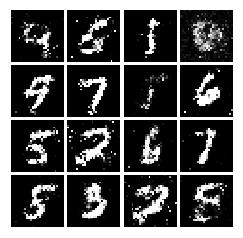


Epoch: 9, D: 1.362, G:0.7492
Epoch: 9, D: 1.348, G:0.7928
Epoch: 9, D: 1.295, G:0.8453
Epoch: 9, D: 1.346, G:1.061
Epoch: 9, D: 1.421, G:0.8801


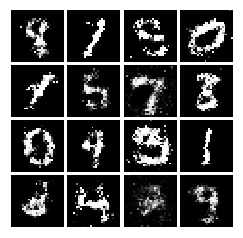


Epoch: 9, D: 1.36, G:0.8159
Epoch: 9, D: 1.378, G:0.7732
Epoch: 9, D: 1.32, G:0.7697
Epoch: 9, D: 1.387, G:0.8477
Final images


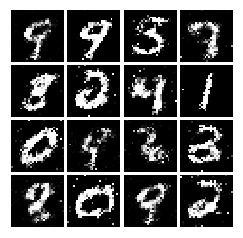

In [20]:
with tf.device("/gpu:0"):
    with get_session() as sess:
        sess.run(tf.global_variables_initializer())
        run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [21]:
def lsgan_loss(scores_real, scores_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
        The score for each real image
    - scores_fake: Tensor, shape[batch_size, 1], output of discriminator
        The score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 1/2 * tf.reduce_mean(tf.pow(scores_fake, 2)) +  1/2 * tf.reduce_mean(tf.pow((scores_real - 1), 2))
    G_loss = 1/2 * tf.reduce_mean(tf.pow((scores_fake - 1), 2))
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [22]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [23]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

_Run the following cell to train your model!_

Epoch: 0, D: 1.245, G:0.2865


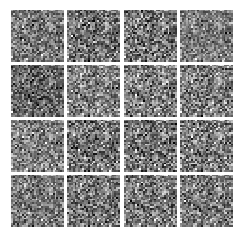


Epoch: 0, D: 0.03573, G:0.364
Epoch: 0, D: 0.01076, G:0.4817
Epoch: 0, D: 0.08349, G:0.5219
Epoch: 0, D: 0.3359, G:0.9398
Epoch: 0, D: 0.187, G:0.793


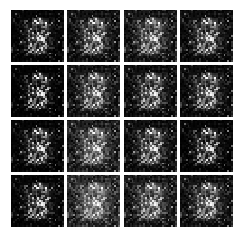


Epoch: 0, D: 0.3167, G:0.4372
Epoch: 0, D: 0.2289, G:0.1632
Epoch: 0, D: 0.1697, G:0.4819
Epoch: 0, D: 0.2297, G:0.4482
Epoch: 1, D: 0.1982, G:0.4367


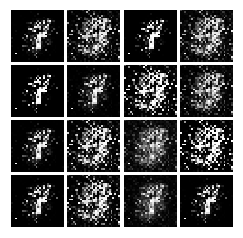


Epoch: 1, D: 0.1095, G:0.3045
Epoch: 1, D: 0.07746, G:0.4083
Epoch: 1, D: 0.1705, G:0.3845
Epoch: 1, D: 0.1511, G:0.6068
Epoch: 1, D: 0.1304, G:0.3119


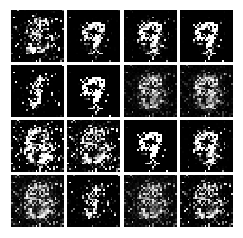


Epoch: 1, D: 0.333, G:0.3779
Epoch: 1, D: 0.1787, G:0.2794
Epoch: 1, D: 0.1228, G:0.3058
Epoch: 1, D: 0.1686, G:0.2137
Epoch: 2, D: 0.1573, G:0.3267


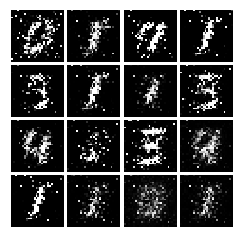


Epoch: 2, D: 0.3472, G:0.3916
Epoch: 2, D: 0.1661, G:0.2192
Epoch: 2, D: 0.161, G:0.2423
Epoch: 2, D: 0.1511, G:0.2107
Epoch: 2, D: 0.1399, G:0.357


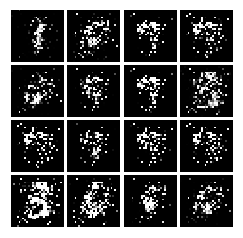


Epoch: 2, D: 0.1748, G:0.1853
Epoch: 2, D: 0.1557, G:0.3742
Epoch: 2, D: 0.1366, G:0.2784
Epoch: 2, D: 0.19, G:0.1809
Epoch: 3, D: 0.1679, G:0.2749


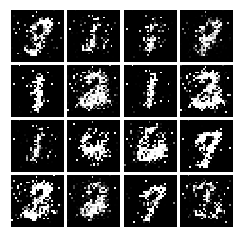


Epoch: 3, D: 0.2249, G:0.07849
Epoch: 3, D: 0.202, G:0.2193
Epoch: 3, D: 0.1611, G:0.3829
Epoch: 3, D: 0.1911, G:0.5056
Epoch: 3, D: 0.2298, G:0.2281


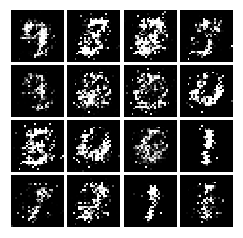


Epoch: 3, D: 0.1911, G:0.3698
Epoch: 3, D: 0.3783, G:0.08405
Epoch: 3, D: 0.2011, G:0.2153
Epoch: 3, D: 0.1922, G:0.1676
Epoch: 4, D: 0.2083, G:0.1967


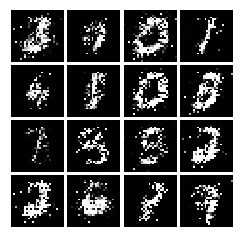


Epoch: 4, D: 0.2409, G:0.2209
Epoch: 4, D: 0.1811, G:0.2407
Epoch: 4, D: 0.1953, G:0.2069
Epoch: 4, D: 0.2293, G:0.2012
Epoch: 4, D: 0.2401, G:0.2585


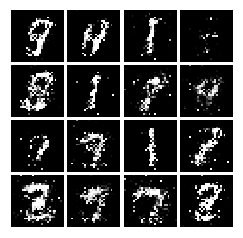


Epoch: 4, D: 0.1964, G:0.2298
Epoch: 4, D: 0.2243, G:0.2103
Epoch: 4, D: 0.2347, G:0.2121
Epoch: 4, D: 0.2058, G:0.1942
Epoch: 5, D: 0.2396, G:0.231


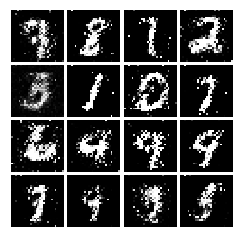


Epoch: 5, D: 0.2277, G:0.1935
Epoch: 5, D: 0.2134, G:0.2214
Epoch: 5, D: 0.2277, G:0.3164
Epoch: 5, D: 0.2481, G:0.1735
Epoch: 5, D: 0.2355, G:0.1598


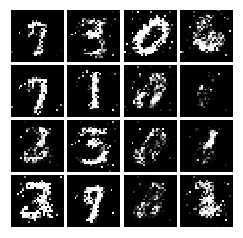


Epoch: 5, D: 0.2295, G:0.1681
Epoch: 5, D: 0.2236, G:0.2033
Epoch: 5, D: 0.2086, G:0.1893
Epoch: 5, D: 0.2372, G:0.203
Epoch: 6, D: 0.2074, G:0.1888


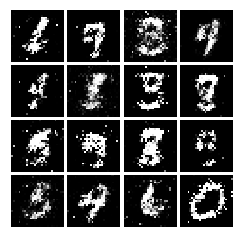


Epoch: 6, D: 0.2323, G:0.1634
Epoch: 6, D: 0.2234, G:0.1867
Epoch: 6, D: 0.2043, G:0.1926
Epoch: 6, D: 0.209, G:0.1673
Epoch: 6, D: 0.2118, G:0.1817


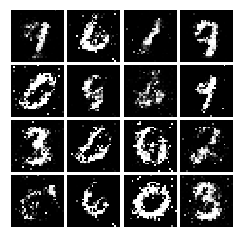


Epoch: 6, D: 0.2463, G:0.1552
Epoch: 6, D: 0.2201, G:0.1846
Epoch: 6, D: 0.2469, G:0.1506
Epoch: 6, D: 0.2156, G:0.1834
Epoch: 7, D: 0.2809, G:0.1691


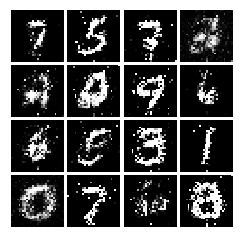


Epoch: 7, D: 0.2412, G:0.1817
Epoch: 7, D: 0.2236, G:0.1561
Epoch: 7, D: 0.2303, G:0.1985
Epoch: 7, D: 0.2229, G:0.159
Epoch: 7, D: 0.225, G:0.1708


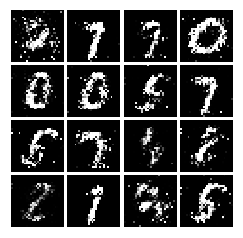


Epoch: 7, D: 0.2243, G:0.1617
Epoch: 7, D: 0.2261, G:0.1824
Epoch: 7, D: 0.2451, G:0.1584
Epoch: 7, D: 0.2373, G:0.161
Epoch: 8, D: 0.2595, G:0.1701


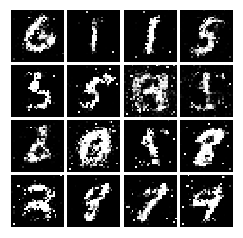


Epoch: 8, D: 0.237, G:0.1686
Epoch: 8, D: 0.2511, G:0.1787
Epoch: 8, D: 0.2205, G:0.1894
Epoch: 8, D: 0.2369, G:0.181
Epoch: 8, D: 0.2392, G:0.1929


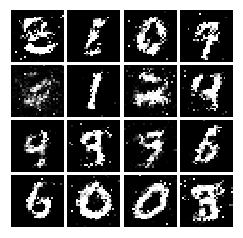


Epoch: 8, D: 0.2505, G:0.1626
Epoch: 8, D: 0.2274, G:0.1714
Epoch: 8, D: 0.2153, G:0.1722
Epoch: 8, D: 0.2368, G:0.1579
Epoch: 9, D: 0.2328, G:0.1534


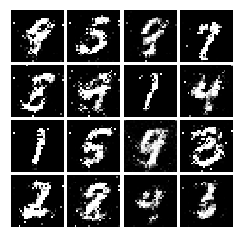


Epoch: 9, D: 0.2428, G:0.1425
Epoch: 9, D: 0.2519, G:0.1521
Epoch: 9, D: 0.2111, G:0.1972
Epoch: 9, D: 0.2276, G:0.1349
Epoch: 9, D: 0.2326, G:0.1641


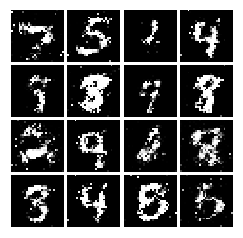


Epoch: 9, D: 0.2275, G:0.1631
Epoch: 9, D: 0.2387, G:0.148
Epoch: 9, D: 0.2205, G:0.1637
Epoch: 9, D: 0.2469, G:0.1587
Final images


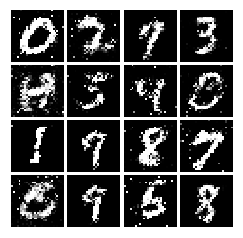

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [38]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        Wconv1 = tf.get_variable("Wconv1", shape = [5, 5, 1, 32])
        bconv1 = tf.get_variable("bconv1", shape = [32])
        Wconv2 = tf.get_variable("Wconv2", shape = [5, 5, 32, 64])
        bconv2 = tf.get_variable("bconv2", shape = [64])
        
        W1 = tf.get_variable("W1", shape = [1024 , 1024])
        b1 = tf.get_variable("b1", shape = [1024])
        W2 = tf.get_variable("W2", shape = [1024,1])
        b2 = tf.get_variable("b2", shape = [1])
        
        alpha = 1e-2
        
        a1 = tf.reshape(x, [-1, 28, 28, 1])
        h1 = tf.nn.conv2d(a1, Wconv1, strides = [1, 1, 1, 1], padding = 'VALID') + bconv1
        a2 = leaky_relu(h1, alpha)
        a2_pool = tf.nn.max_pool(a2, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        
        h2 = tf.nn.conv2d(a2_pool, Wconv2, strides = [1, 1, 1, 1], padding = 'VALID') + bconv2
        a3 = leaky_relu(h2, alpha)
        a3_pool = tf.nn.max_pool(a3, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        a3_flat = tf.reshape(a3_pool,[-1,1024])
        
        h3 = tf.matmul(a3_flat, W1) + b1
        a4 = leaky_relu(h3, alpha)
        logits = tf.matmul(a4, W2) + b2
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.layers` for your implementation. You might find the documentation for [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [45]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        L1 = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        L1 = tf.layers.batch_normalization(L1, training = True)
        
        L2 = tf.layers.dense(L1, 7 * 7 * 128, activation = tf.nn.relu)
        L2 = tf.layers.batch_normalization(L2, training = True)
        L2 = tf.reshape(L2, [-1, 7, 7, 128])
        
        L3 = tf.layers.conv2d_transpose(L2, filters = 64, kernel_size = (4,4), strides = (2,2), padding = 'same', activation = tf.nn.relu)
        L3 = tf.layers.batch_normalization(L3, training = True)
        
        img = tf.layers.conv2d_transpose(L3, filters = 1, kernel_size = (4,4), strides = (2,2), padding = 'same', activation = tf.nn.tanh)

        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [47]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

Epoch: 0, D: 1.44, G:0.295


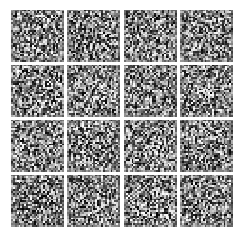


Epoch: 0, D: 1.016, G:1.48
Epoch: 0, D: 0.7959, G:1.291
Epoch: 0, D: 1.178, G:0.8586
Epoch: 0, D: 1.07, G:0.9508
Epoch: 0, D: 2.158, G:1.572


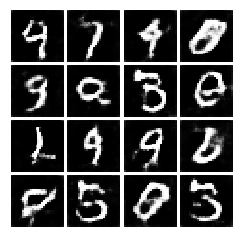


Epoch: 0, D: 1.079, G:1.056
Epoch: 0, D: 1.16, G:1.198
Epoch: 0, D: 1.199, G:0.8189
Epoch: 0, D: 1.105, G:1.091
Epoch: 1, D: 1.179, G:0.8489


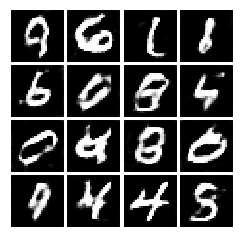


Epoch: 1, D: 1.121, G:0.8971
Epoch: 1, D: 1.235, G:0.74
Epoch: 1, D: 1.327, G:0.9789
Epoch: 1, D: 1.134, G:0.759
Epoch: 1, D: 1.328, G:0.6656


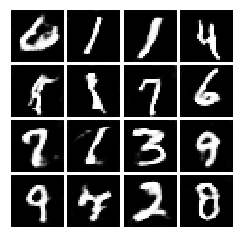


Epoch: 1, D: 1.294, G:0.9998
Epoch: 1, D: 1.226, G:0.9142
Epoch: 1, D: 1.225, G:0.9413
Epoch: 1, D: 1.093, G:1.174
Epoch: 2, D: 1.287, G:1.142


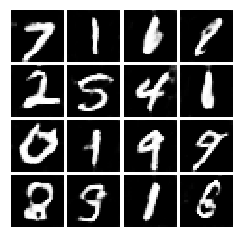


Epoch: 2, D: 1.16, G:0.7978
Epoch: 2, D: 1.094, G:0.6353
Epoch: 2, D: 1.297, G:0.7224
Epoch: 2, D: 1.181, G:0.9134
Epoch: 2, D: 1.364, G:1.623


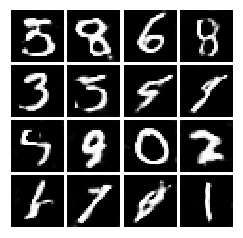


Epoch: 2, D: 1.315, G:0.9012
Epoch: 2, D: 1.152, G:0.9604
Epoch: 2, D: 1.22, G:0.9568
Epoch: 2, D: 1.241, G:0.8268
Epoch: 3, D: 1.404, G:1.415


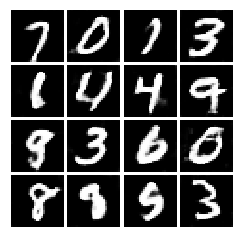


Epoch: 3, D: 1.22, G:0.9385
Epoch: 3, D: 1.186, G:1.565
Epoch: 3, D: 1.33, G:1.687
Epoch: 3, D: 1.129, G:1.111
Epoch: 3, D: 1.284, G:0.9433


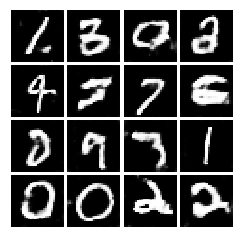


Epoch: 3, D: 1.277, G:0.3662
Epoch: 3, D: 1.156, G:0.9961
Epoch: 3, D: 1.219, G:0.9124
Epoch: 3, D: 1.106, G:0.8867
Epoch: 4, D: 1.273, G:0.9896


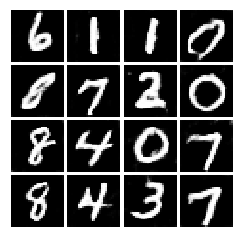


Epoch: 4, D: 1.158, G:0.8054
Epoch: 4, D: 1.054, G:0.9026
Epoch: 4, D: 1.359, G:1.238
Epoch: 4, D: 1.129, G:0.8382
Epoch: 4, D: 1.296, G:0.685


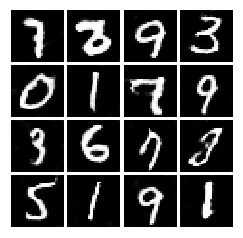


Epoch: 4, D: 1.191, G:0.9332
Epoch: 4, D: 1.054, G:1.05
Epoch: 4, D: 1.1, G:0.9611
Epoch: 4, D: 1.028, G:1.262
Final images


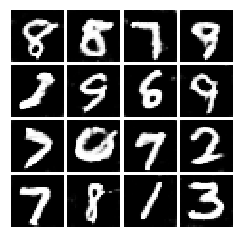

In [48]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x) with step size $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |   1   |   -1  |   -2  |   -1  |   1   
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |  -1   |  -2   |   -1  |   1   |    2  |   1   
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:
Yes They can. When generator distribution gets same as real data distribution, gan is converged to global optimum

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient

### Your answer:
It's not a good sign. Because, decreasement of generator loss means that generator suceeds to fool discriminator. Therefore, discriminator has somewhat failed to learn parameters to discriminate, which cannot ensure the quality of the generator